In [1]:
import pandas as pd
import numpy as np
import gc


In [2]:
electricity = pd.read_csv("electricity.csv")
metadata = pd.read_csv("metadata.csv")
weather = pd.read_csv("weather.csv")


In [3]:
def reduce_memory(df):
    for col in df.columns:
        if df[col].dtype == 'float64':
            df[col] = df[col].astype('float32')
        elif df[col].dtype == 'int64':
            df[col] = df[col].astype('int32')
    return df

electricity = reduce_memory(electricity)
metadata = reduce_memory(metadata)
weather = reduce_memory(weather)

gc.collect()


0

In [4]:
electricity["timestamp"] = pd.to_datetime(electricity["timestamp"])

electricity_long = electricity.melt(
    id_vars="timestamp",
    var_name="building_id",
    value_name="electricity"
)

print("After melt:", electricity_long.shape)


After melt: (27684432, 3)


In [5]:
# Keep only first 100 buildings for safe processing
buildings = electricity_long["building_id"].unique()[:100]

electricity_long = electricity_long[
    electricity_long["building_id"].isin(buildings)
]

print("After subset:", electricity_long.shape)


After subset: (1754400, 3)


In [6]:
electricity_long = electricity_long.dropna()


In [7]:
electricity_long = electricity_long[
    electricity_long["electricity"] >= 0
]


In [8]:
lower = electricity_long["electricity"].quantile(0.01)
upper = electricity_long["electricity"].quantile(0.99)

electricity_long["electricity"] = electricity_long["electricity"].clip(lower, upper)


In [9]:
metadata["building_id"] = metadata["building_id"].astype(str).str.strip()
electricity_long["building_id"] = electricity_long["building_id"].astype(str).str.strip()


In [10]:
metadata = metadata[
    metadata["building_id"].isin(buildings)
]


In [11]:
data = electricity_long.merge(
    metadata,
    on="building_id",
    how="left"
)

print("After metadata merge:", data.shape)


After metadata merge: (1406259, 34)


In [12]:
weather["timestamp"] = pd.to_datetime(weather["timestamp"])


In [13]:
print("site_id in metadata:", "site_id" in metadata.columns)


site_id in metadata: True


In [14]:
site_ids = metadata["site_id"].unique()

weather = weather[
    weather["site_id"].isin(site_ids)
]


In [15]:
if "site_id" in data.columns:
    data = data.merge(
        weather,
        on=["site_id", "timestamp"],
        how="left"
    )

print("After weather merge:", data.shape)


After weather merge: (1406259, 42)


In [16]:
data = data.dropna(axis=1, how="all")


In [17]:
num_cols = data.select_dtypes(include=np.number).columns

for col in num_cols:
    data[col] = data[col].fillna(data[col].median())


In [18]:
cat_cols = data.select_dtypes(include="object").columns

for col in cat_cols:
    data[col] = data[col].fillna("unknown")


In [19]:
data.shape

(1406259, 29)

In [20]:
data.isnull().sum().sum()

np.int64(0)

In [21]:
data.duplicated().sum()

np.int64(0)

In [22]:
data.describe()

,timestamp,electricity_x,building_id_kaggle,site_id_kaggle,sqm,sqft,lat,lng,yearbuilt,airTemperature,cloudCoverage,dewTemperature,precipDepth1HR,precipDepth6HR,seaLvlPressure,windDirection,windSpeed
count,1406259,1.406259e+06,1.406259e+06,1406259.0,1.406259e+06,1.406259e+06,1.406259e+06,1.406259e+06,1.406259e+06,1.406259e+06,1.406259e+06,1.406259e+06,1.406259e+06,1.406259e+06,1.406259e+06,1.406259e+06,1.406259e+06
mean,2017-03-11 20:11:22.363632384,1.101584e+02,5.133735e+01,0.0,8.263063e+03,8.894291e+04,2.851763e+01,-8.137897e+01,1.995663e+03,2.358910e+01,2.550802e+00,1.837470e+01,1.249837e+00,4.356776e+00,1.017652e+03,1.456406e+02,3.328612e+00
min,2016-01-01 00:00:00,5.571000e-01,0.000000e+00,0.0,2.630000e+01,2.830000e+02,2.851769e+01,-8.137904e+01,1.968000e+03,1.700000e+00,0.000000e+00,-1.060000e+01,-1.000000e+00,-1.000000e+00,9.810000e+02,0.000000e+00,0.000000e+00
25%,2016-10-15 18:00:00,2.912560e+01,2.400000e+01,0.0,1.752200e+03,1.886000e+04,2.851769e+01,-8.137904e+01,1.985000e+03,2.060000e+01,2.000000e+00,1.500000e+01,0.000000e+00,3.000000e+00,1.015300e+03,5.000000e+01,2.100000e+00
50%,2017-03-12 10:00:00,6.751300e+01,5.100000e+01,0.0,4.919900e+03,5.295700e+04,2.851769e+01,-8.137904e+01,2.001000e+03,2.440000e+01,2.000000e+00,2.000000e+01,0.000000e+00,3.000000e+00,1.017700e+03,1.200000e+02,3.100000e+00
75%,2017-08-06 15:00:00,1.406271e+02,7.900000e+01,0.0,9.595600e+03,1.032860e+05,2.851769e+01,-8.137904e+01,2.007000e+03,2.720000e+01,4.000000e+00,2.280000e+01,0.000000e+00,3.000000e+00,1.020100e+03,2.300000e+02,4.600000e+00
max,2017-12-31 23:00:00,5.902739e+02,1.040000e+02,0.0,4.528400e+04,4.874330e+05,2.851769e+01,-8.137904e+01,2.016000e+03,3.610000e+01,9.000000e+00,2.670000e+01,5.970000e+02,7.700000e+02,1.036300e+03,3.600000e+02,2.420000e+01
std,NaN,1.238310e+02,3.049221e+01,0.0,1.014964e+04,1.092187e+05,2.072793e-01,9.059083e-01,1.863329e+01,5.436678e+00,1.660557e+00,5.934466e+00,1.332574e+01,1.911089e+01,6.771804e+00,1.146778e+02,2.234926e+00


In [23]:
data.columns

Index(['timestamp', 'building_id', 'electricity_x', 'site_id',
       'building_id_kaggle', 'site_id_kaggle', 'primaryspaceusage',
       'sub_primaryspaceusage', 'sqm', 'sqft', 'lat', 'lng', 'timezone',
       'electricity_y', 'chilledwater', 'water', 'irrigation', 'gas',
       'yearbuilt', 'eui', 'leed_level', 'airTemperature', 'cloudCoverage',
       'dewTemperature', 'precipDepth1HR', 'precipDepth6HR', 'seaLvlPressure',
       'windDirection', 'windSpeed'],
      dtype='object')

In [24]:
data.isnull().sum().sum()

np.int64(0)

In [25]:
data.isnull().sum()/len(data)*100

,0
timestamp,0.0
building_id,0.0
electricity_x,0.0
site_id,0.0
building_id_kaggle,0.0
site_id_kaggle,0.0
primaryspaceusage,0.0
sub_primaryspaceusage,0.0
sqm,0.0
sqft,0.0


In [26]:
data.duplicated().sum()

np.int64(0)

In [27]:
data = data.sort_values(["building_id", "timestamp"])

time_diff = data.groupby("building_id")["timestamp"].diff()

print("Unique time differences:")
print(time_diff.value_counts().head())


Unique time differences:
timestamp
0 days 01:00:00    1403686
0 days 02:00:00        424
0 days 06:00:00        180
0 days 03:00:00        131
0 days 07:00:00        127
Name: count, dtype: int64


In [28]:
building_counts = data["building_id"].value_counts()

print("Min rows per building:", building_counts.min())
print("Max rows per building:", building_counts.max())


Min rows per building: 8849
Max rows per building: 15611


In [29]:
print("Negative electricity values:",
      (data["electricity_x"] < 0).sum())

print("Zero electricity values:",
      (data["electricity_x"] == 0).sum())


Negative electricity values: 0
Zero electricity values: 0


In [30]:
print("Electricity min:", data["electricity_x"].min())
print("Electricity max:", data["electricity_x"].max())


Electricity min: 0.5570999979972839
Electricity max: 590.27392578125


EDA

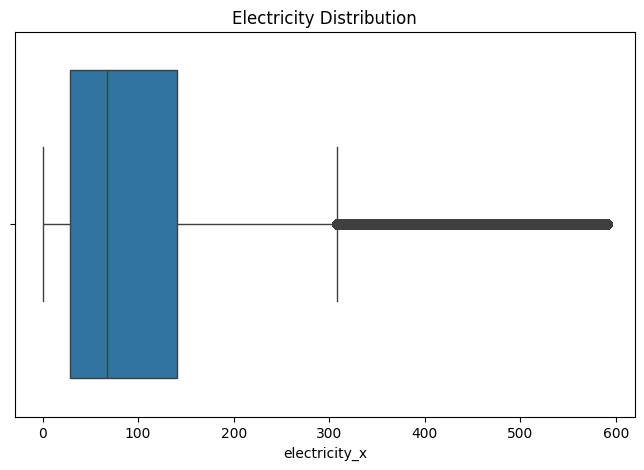

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.boxplot(x=data["electricity_x"])
plt.title("Electricity Distribution")
plt.show()


In [32]:
Q1 = data["electricity_x"].quantile(0.25)
Q3 = data["electricity_x"].quantile(0.75)
IQR = Q3 - Q1

outliers = data[
    (data["electricity_x"] < Q1 - 1.5*IQR) |
    (data["electricity_x"] > Q3 + 1.5*IQR)
]

print("Outlier count:", len(outliers))


Outlier count: 125021


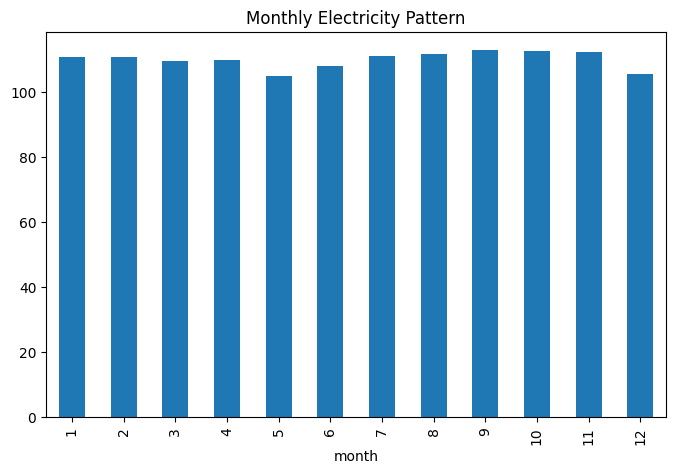

In [33]:
data["month"] = data["timestamp"].dt.month
monthly_avg = data.groupby("month")["electricity_x"].mean()

monthly_avg.plot(kind="bar", figsize=(8,5))
plt.title("Monthly Electricity Pattern")
plt.show()


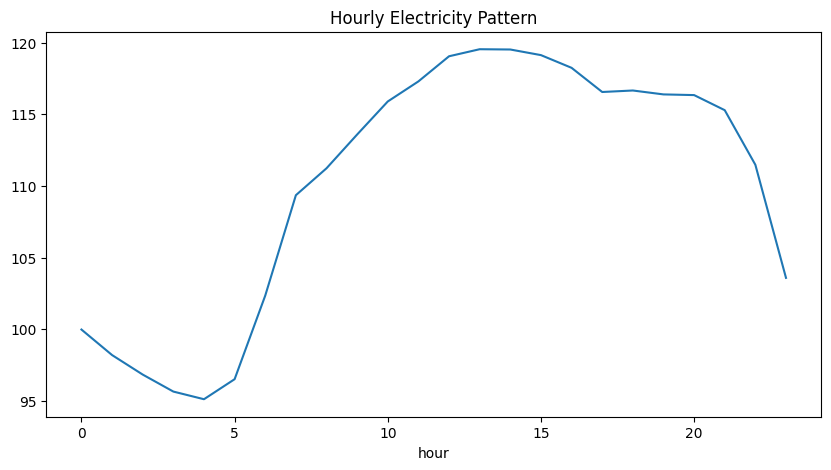

In [34]:
data["hour"] = data["timestamp"].dt.hour
hourly_avg = data.groupby("hour")["electricity_x"].mean()

hourly_avg.plot(figsize=(10,5))
plt.title("Hourly Electricity Pattern")
plt.show()


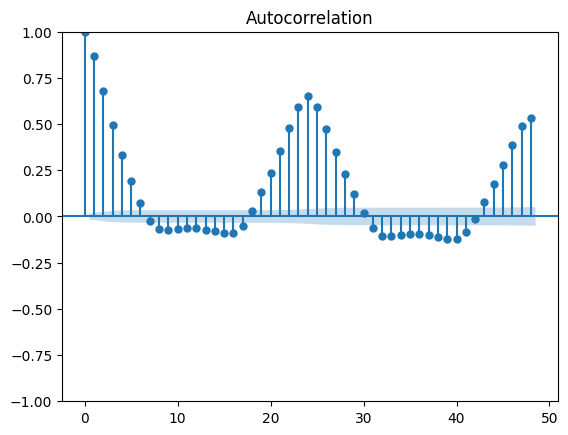

In [35]:
from statsmodels.graphics.tsaplots import plot_acf

sample_building = data["building_id"].iloc[0]
sample_df = data[data["building_id"] == sample_building]

plot_acf(sample_df["electricity_x"].dropna(), lags=48)
plt.show()


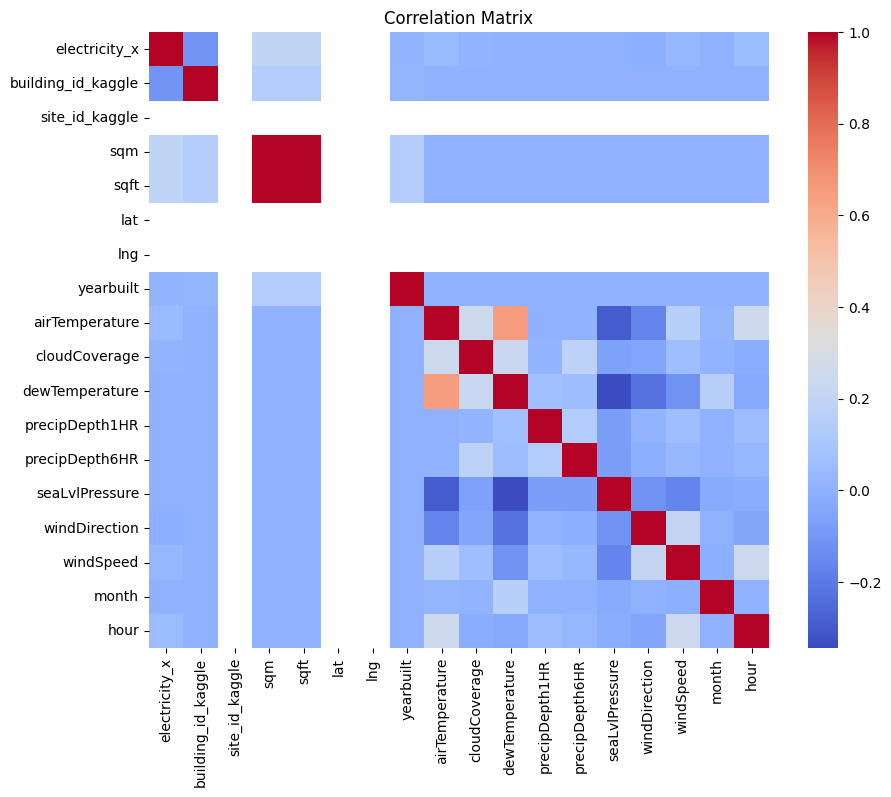

In [36]:
plt.figure(figsize=(10,8))
sns.heatmap(
    data.select_dtypes(include="number").corr(),
    cmap="coolwarm",
    annot=False
)
plt.title("Correlation Matrix")
plt.show()


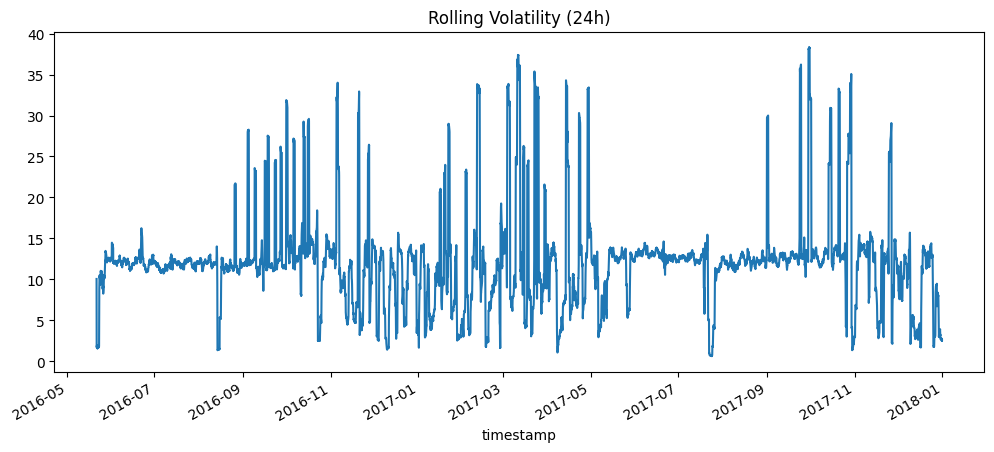

In [37]:
rolling_std = sample_df.set_index("timestamp")["electricity_x"].rolling(24).std()

rolling_std.plot(figsize=(12,5))
plt.title("Rolling Volatility (24h)")
plt.show()


In [38]:
quality_report = {
    "Total Rows": len(data),
    "Total Columns": len(data.columns),
    "Missing Values": data.isnull().sum().sum(),
    "Duplicate Rows": data.duplicated().sum(),
    "Negative Electricity": (data["electricity_x"] < 0).sum(),
    "Zero Electricity": (data["electricity_x"] == 0).sum(),
    "Min Electricity": data["electricity_x"].min(),
    "Max Electricity": data["electricity_x"].max()
}

print("DATA QUALITY REPORT")
for k, v in quality_report.items():
    print(f"{k}: {v}")


DATA QUALITY REPORT
Total Rows: 1406259
Total Columns: 31
Missing Values: 0
Duplicate Rows: 0
Negative Electricity: 0
Zero Electricity: 0
Min Electricity: 0.5570999979972839
Max Electricity: 590.27392578125


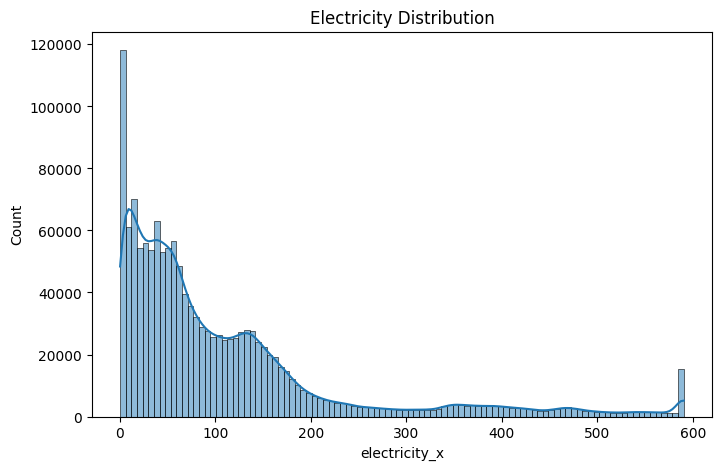

In [39]:
plt.figure(figsize=(8,5))
sns.histplot(data["electricity_x"], bins=100, kde=True)
plt.title("Electricity Distribution")
plt.show()

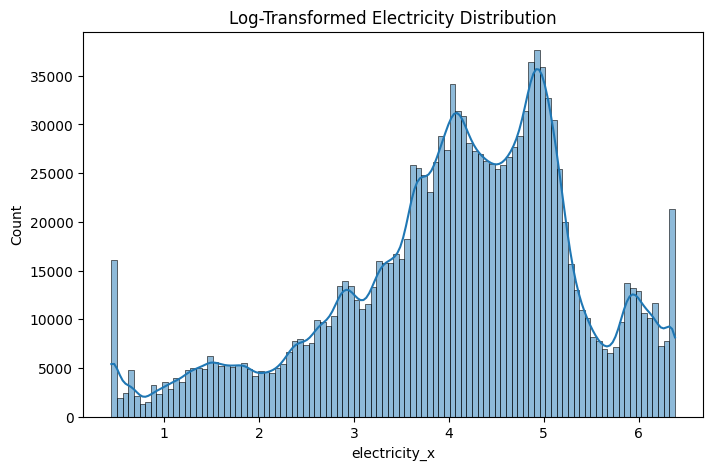

In [40]:
plt.figure(figsize=(8,5))
sns.histplot(np.log1p(data["electricity_x"]), bins=100, kde=True)
plt.title("Log-Transformed Electricity Distribution")
plt.show()


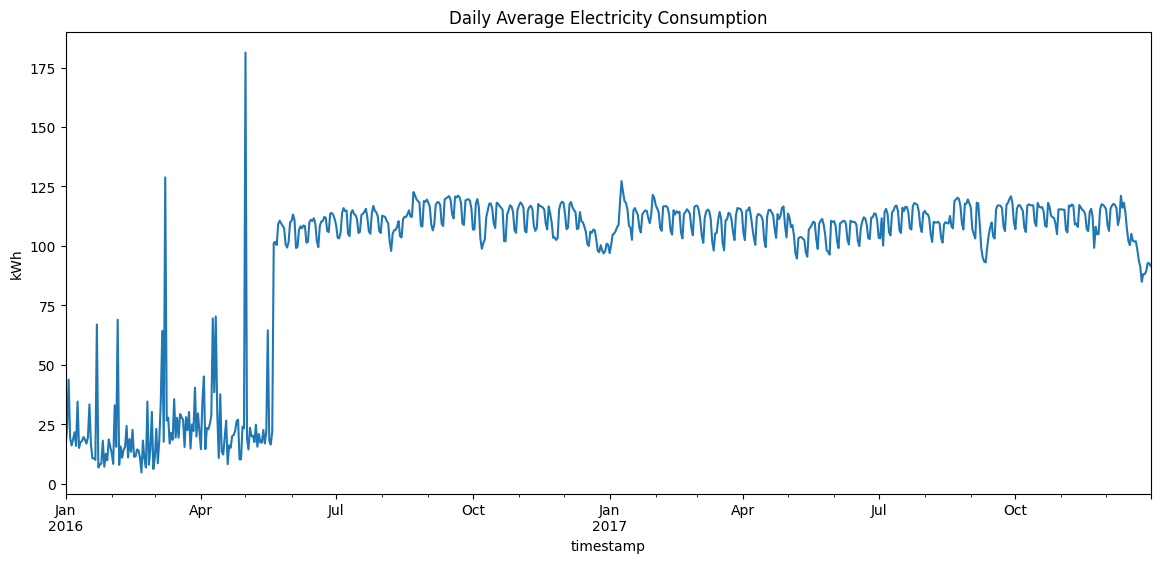

In [41]:
daily_avg = data.set_index("timestamp").resample("D")["electricity_x"].mean()

plt.figure(figsize=(14,6))
daily_avg.plot()
plt.title("Daily Average Electricity Consumption")
plt.ylabel("kWh")
plt.show()


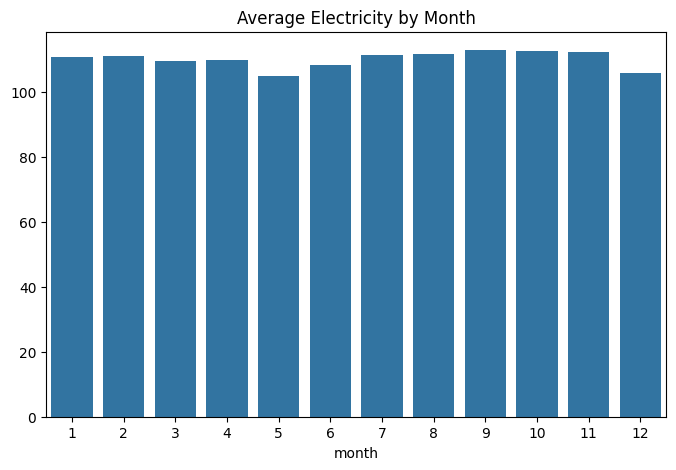

In [42]:
data["month"] = data["timestamp"].dt.month

monthly_pattern = data.groupby("month")["electricity_x"].mean()

plt.figure(figsize=(8,5))
sns.barplot(x=monthly_pattern.index, y=monthly_pattern.values)
plt.title("Average Electricity by Month")
plt.show()


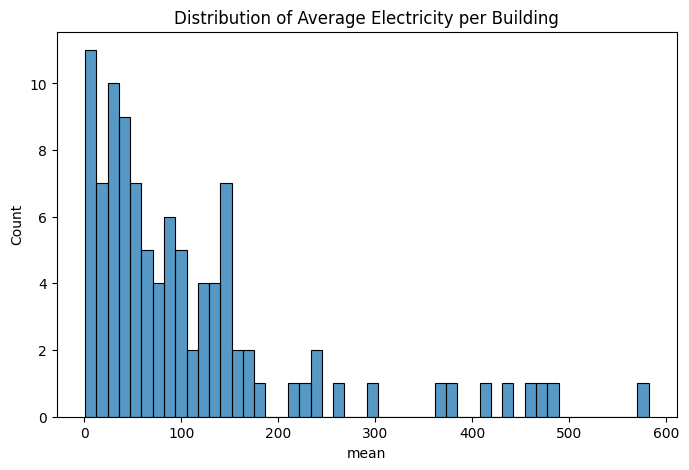

In [43]:
building_stats = data.groupby("building_id")["electricity_x"].agg(["mean","std"])

plt.figure(figsize=(8,5))
sns.histplot(building_stats["mean"], bins=50)
plt.title("Distribution of Average Electricity per Building")
plt.show()


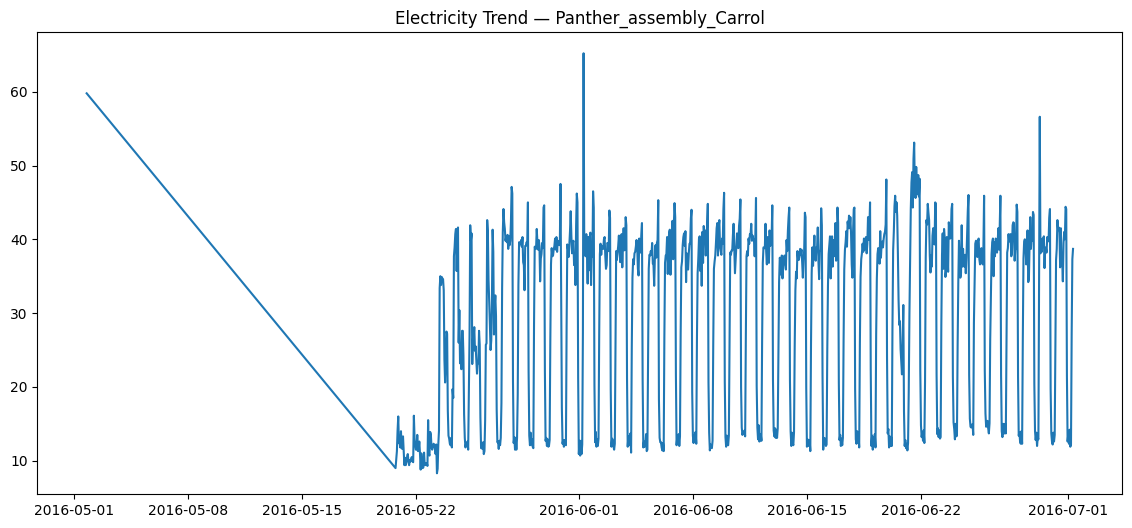

In [44]:
sample_building = data["building_id"].iloc[0]
sample_df = data[data["building_id"] == sample_building].copy()

plt.figure(figsize=(14,6))
plt.plot(sample_df["timestamp"][:1000],
         sample_df["electricity_x"][:1000])
plt.title(f"Electricity Trend — {sample_building}")
plt.show()


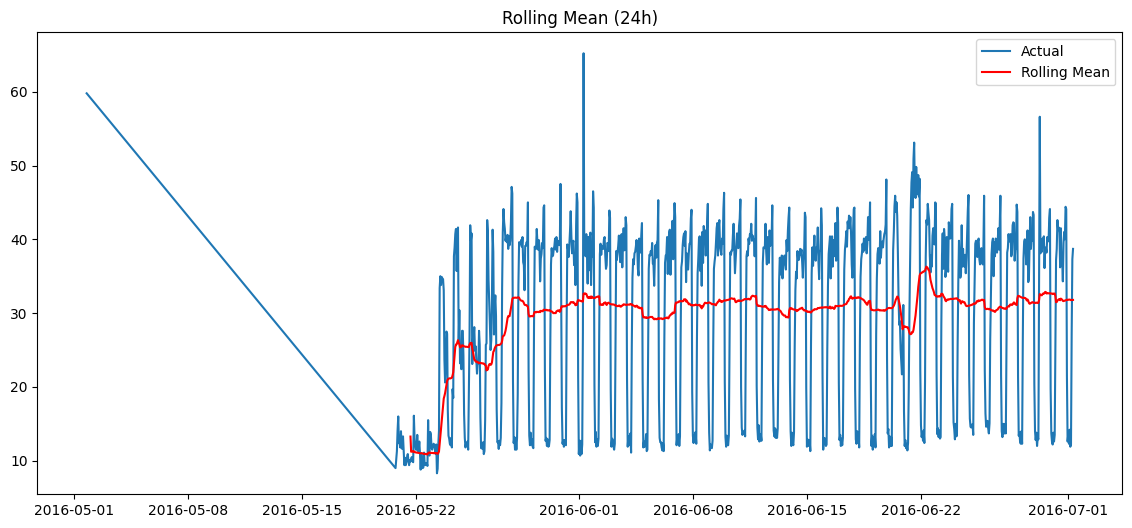

In [45]:
sample_df = sample_df.set_index("timestamp")

sample_df["rolling_mean"] = sample_df["electricity_x"].rolling(24).mean()
sample_df["rolling_std"] = sample_df["electricity_x"].rolling(24).std()

plt.figure(figsize=(14,6))
plt.plot(sample_df["electricity_x"][:1000], label="Actual")
plt.plot(sample_df["rolling_mean"][:1000], label="Rolling Mean", color="red")
plt.legend()
plt.title("Rolling Mean (24h)")
plt.show()


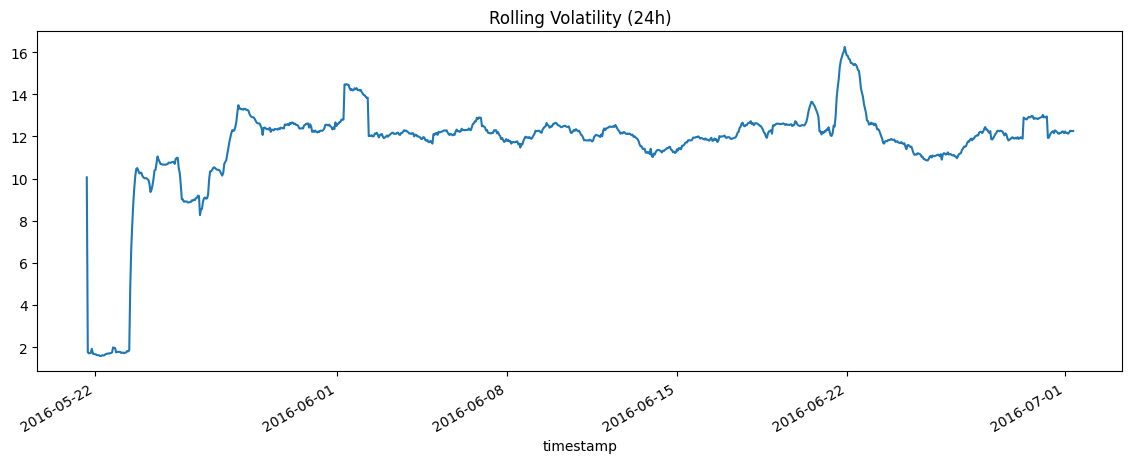

In [46]:
plt.figure(figsize=(14,5))
sample_df["rolling_std"][:1000].plot()
plt.title("Rolling Volatility (24h)")
plt.show()


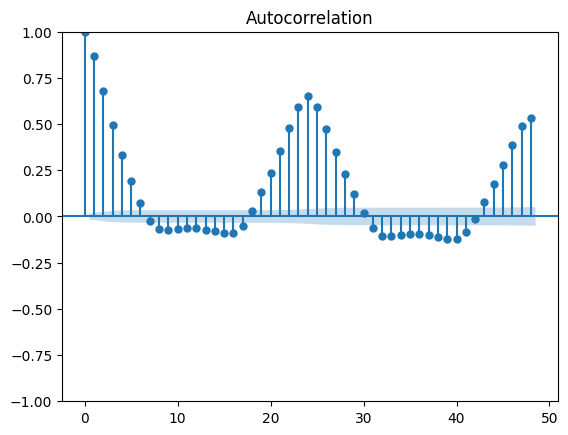

In [47]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(sample_df["electricity_x"].dropna(), lags=48)
plt.show()


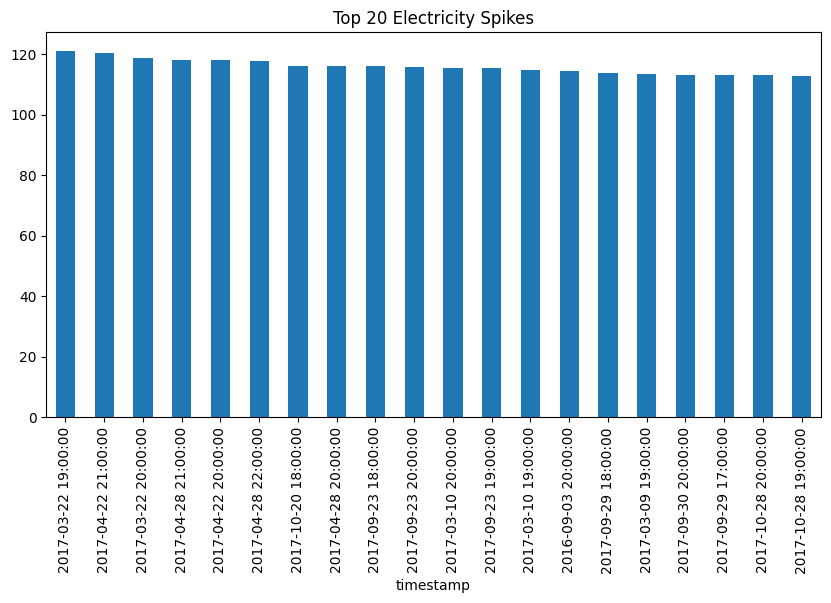

In [48]:
top_spikes = sample_df["electricity_x"].nlargest(20)

plt.figure(figsize=(10,5))
top_spikes.plot(kind="bar")
plt.title("Top 20 Electricity Spikes")
plt.show()


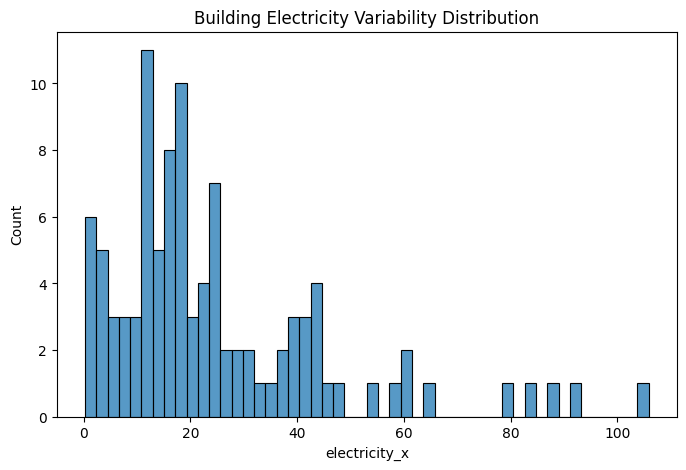

In [49]:
building_variance = data.groupby("building_id")["electricity_x"].std()

plt.figure(figsize=(8,5))
sns.histplot(building_variance, bins=50)
plt.title("Building Electricity Variability Distribution")
plt.show()


Feature Engineering

In [50]:
data = data.sort_values(["building_id", "timestamp"])


In [51]:
data["hour"] = data["timestamp"].dt.hour
data["day_of_week"] = data["timestamp"].dt.dayofweek
data["month"] = data["timestamp"].dt.month
data["day"] = data["timestamp"].dt.day
data["weekofyear"] = data["timestamp"].dt.isocalendar().week

data["is_weekend"] = data["day_of_week"].isin([5,6]).astype(int)


In [52]:
data["hour_sin"] = np.sin(2*np.pi*data["hour"]/24)
data["hour_cos"] = np.cos(2*np.pi*data["hour"]/24)

data["month_sin"] = np.sin(2*np.pi*data["month"]/12)
data["month_cos"] = np.cos(2*np.pi*data["month"]/12)


In [53]:
data["lag_1"] = data.groupby("building_id")["electricity_x"].shift(1)
data["lag_24"] = data.groupby("building_id")["electricity_x"].shift(24)
data["lag_168"] = data.groupby("building_id")["electricity_x"].shift(168)  # 7 days


In [54]:
data["rolling_mean_24"] = data.groupby("building_id")["electricity_x"].transform(
    lambda x: x.rolling(24).mean()
)

data["rolling_std_24"] = data.groupby("building_id")["electricity_x"].transform(
    lambda x: x.rolling(24).std()
)

data["rolling_mean_168"] = data.groupby("building_id")["electricity_x"].transform(
    lambda x: x.rolling(168).mean()
)


In [55]:
data["z_score"] = (
    (data["electricity_x"] - data["rolling_mean_24"]) /
    (data["rolling_std_24"] + 1e-5)
)


In [56]:
data["pct_change_1h"] = data.groupby("building_id")["electricity_x"].pct_change()
data["abs_change_1h"] = data.groupby("building_id")["electricity_x"].diff()


In [57]:
data["is_peak_hour"] = data["hour"].isin([8,9,10,11,12,13,14,15,16,17]).astype(int)


In [58]:
data["volatility_24"] = data.groupby("building_id")["electricity_x"].transform(
    lambda x: x.rolling(24).std()
)


In [59]:
data = data.fillna(0)


In [60]:
data.columns

Index(['timestamp', 'building_id', 'electricity_x', 'site_id',
       'building_id_kaggle', 'site_id_kaggle', 'primaryspaceusage',
       'sub_primaryspaceusage', 'sqm', 'sqft', 'lat', 'lng', 'timezone',
       'electricity_y', 'chilledwater', 'water', 'irrigation', 'gas',
       'yearbuilt', 'eui', 'leed_level', 'airTemperature', 'cloudCoverage',
       'dewTemperature', 'precipDepth1HR', 'precipDepth6HR', 'seaLvlPressure',
       'windDirection', 'windSpeed', 'month', 'hour', 'day_of_week', 'day',
       'weekofyear', 'is_weekend', 'hour_sin', 'hour_cos', 'month_sin',
       'month_cos', 'lag_1', 'lag_24', 'lag_168', 'rolling_mean_24',
       'rolling_std_24', 'rolling_mean_168', 'z_score', 'pct_change_1h',
       'abs_change_1h', 'is_peak_hour', 'volatility_24'],
      dtype='object')

In [61]:
len(data.columns)

50

**Model Buiding**(ENSEMBLE)

In [62]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense


In [63]:
feature_cols = [
    "electricity_x",
    "hour_sin", "hour_cos",
    "month_sin", "month_cos",
    "lag_1", "lag_24",
    "rolling_mean_24",
    "rolling_std_24",
    "z_score",
    "pct_change_1h",
    "volatility_24"
]

X = data[feature_cols]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Isolation Forest Model

In [64]:
iso_model = IsolationForest(
    n_estimators=100,
    contamination=0.05,
    random_state=42,
    n_jobs=-1
)

iso_preds = iso_model.fit_predict(X_scaled)

# Convert to 0/1
iso_preds = np.where(iso_preds == -1, 1, 0)

data["iso_anomaly"] = iso_preds


LSTM Autoencoder

In [65]:
sequence_length = 24

def create_sequences(series, seq_len):
    sequences = []
    for i in range(len(series) - seq_len):
        sequences.append(series[i:i+seq_len])
    return np.array(sequences)

electricity_series = data["electricity_x"].values

X_seq = create_sequences(electricity_series, sequence_length)

X_seq = X_seq.reshape((X_seq.shape[0], X_seq.shape[1], 1))


In [66]:
inputs = Input(shape=(sequence_length, 1))

encoded = LSTM(64, activation='relu', return_sequences=False)(inputs)
decoded = RepeatVector(sequence_length)(encoded)
decoded = LSTM(64, activation='relu', return_sequences=True)(decoded)
decoded = TimeDistributed(Dense(1))(decoded)

lstm_model = Model(inputs, decoded)

lstm_model.compile(optimizer='adam', loss='mse')

In [67]:
history = lstm_model.fit(
    X_seq, X_seq,
    epochs=5,   # Keep small to avoid long training
    batch_size=64,
    validation_split=0.1,
    shuffle=False
)


Epoch 1/5
19776/19776 ━━━━━━━━━━━━━━━━━━━━ 774s 39ms/step - loss: 3308615.5000 - val_loss: 895.2092
Epoch 2/5
19776/19776 ━━━━━━━━━━━━━━━━━━━━ 772s 39ms/step - loss: 73122.6016 - val_loss: 1509.1097
Epoch 3/5
19776/19776 ━━━━━━━━━━━━━━━━━━━━ 767s 39ms/step - loss: 31946.7402 - val_loss: 2163.7236
Epoch 4/5
19776/19776 ━━━━━━━━━━━━━━━━━━━━ 810s 39ms/step - loss: 1734.3484 - val_loss: 712.6938
Epoch 5/5
19776/19776 ━━━━━━━━━━━━━━━━━━━━ 787s 40ms/step - loss: 933.0139 - val_loss: 712.3272


In [68]:
X_pred = lstm_model.predict(X_seq)

reconstruction_error = np.mean(
    np.abs(X_pred - X_seq), axis=(1,2)
)

threshold = np.percentile(reconstruction_error, 95)

lstm_anomalies = (reconstruction_error > threshold).astype(int)

# Pad to align with original dataframe
lstm_anomalies = np.concatenate(
    [np.zeros(sequence_length), lstm_anomalies]
)

data["lstm_anomaly"] = lstm_anomalies[:len(data)]


43945/43945 ━━━━━━━━━━━━━━━━━━━━ 392s 9ms/step


In [69]:
data["ensemble_score"] = (
    data["iso_anomaly"] +
    data["lstm_anomaly"]
)

data["final_anomaly"] = (data["ensemble_score"] >= 1).astype(int)


In [70]:
print("Isolation Forest anomalies:",
      data["iso_anomaly"].sum())

print("LSTM anomalies:",
      data["lstm_anomaly"].sum())

print("Final Ensemble anomalies:",
      data["final_anomaly"].sum())


Isolation Forest anomalies: 70313
LSTM anomalies: 70312.0
Final Ensemble anomalies: 84395


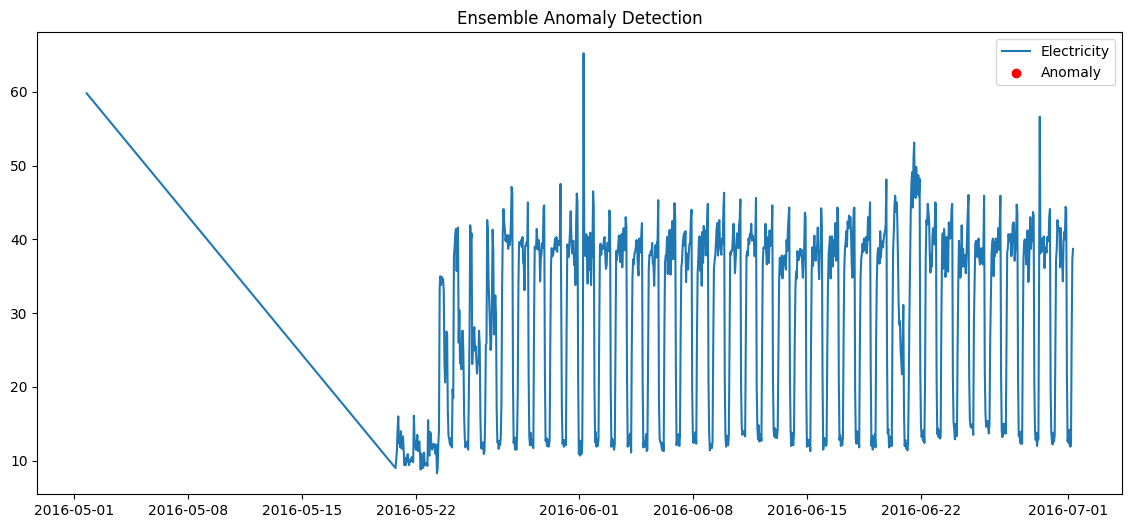

In [71]:
import matplotlib.pyplot as plt

sample_building = data["building_id"].iloc[0]
sample_df = data[data["building_id"] == sample_building]

plt.figure(figsize=(14,6))
plt.plot(sample_df["timestamp"][:1000],
         sample_df["electricity_x"][:1000],
         label="Electricity")

anomaly_points = sample_df[sample_df["final_anomaly"] == 1]

plt.scatter(anomaly_points["timestamp"][:1000],
            anomaly_points["electricity_x"][:1000],
            color="red",
            label="Anomaly")

plt.legend()
plt.title("Ensemble Anomaly Detection")
plt.show()


MODEL EVALUATION

In [72]:
total_points = len(data)

iso_rate = data["iso_anomaly"].sum() / total_points * 100
lstm_rate = data["lstm_anomaly"].sum() / total_points * 100
ensemble_rate = data["final_anomaly"].sum() / total_points * 100

print(f"Isolation Forest Anomaly Rate: {iso_rate:.2f}%")
print(f"LSTM Anomaly Rate: {lstm_rate:.2f}%")
print(f"Ensemble Anomaly Rate: {ensemble_rate:.2f}%")


Isolation Forest Anomaly Rate: 5.00%
LSTM Anomaly Rate: 5.00%
Ensemble Anomaly Rate: 6.00%


In [73]:
agreement = (
    (data["iso_anomaly"] == 1) &
    (data["lstm_anomaly"] == 1)
).sum()

print("Both models agree on:", agreement, "points")


Both models agree on: 56230 points


In [74]:
print("Agreement %:",
      agreement / data["final_anomaly"].sum() * 100)


Agreement %: 66.62716985603413


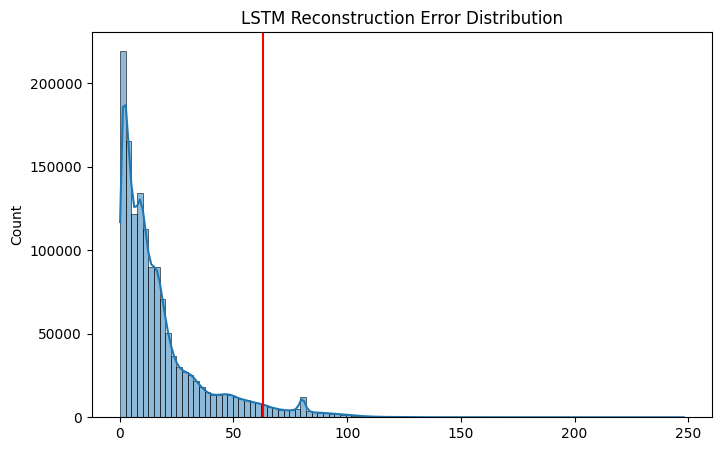

In [75]:
plt.figure(figsize=(8,5))
sns.histplot(reconstruction_error, bins=100, kde=True)
plt.axvline(threshold, color="red")
plt.title("LSTM Reconstruction Error Distribution")
plt.show()


In [76]:
from sklearn.inspection import permutation_importance
import numpy as np

# Custom scoring function using decision_function
def iso_scorer(estimator, X, y=None):
    return np.mean(estimator.decision_function(X))

result = permutation_importance(
    iso_model,
    X_scaled,
    None,                 # No true labels
    scoring=iso_scorer,   # Custom scoring
    n_repeats=5,
    random_state=42,
    n_jobs=-1
)

feature_importance = pd.Series(
    result.importances_mean,
    index=feature_cols
).sort_values(ascending=False)

print(feature_importance)


electricity_x      0.008301
lag_1              0.007509
rolling_mean_24    0.007034
lag_24             0.006197
volatility_24      0.004151
rolling_std_24     0.003676
hour_sin           0.000962
hour_cos           0.000833
z_score            0.000569
pct_change_1h      0.000149
month_cos          0.000103
month_sin         -0.000010
dtype: float64


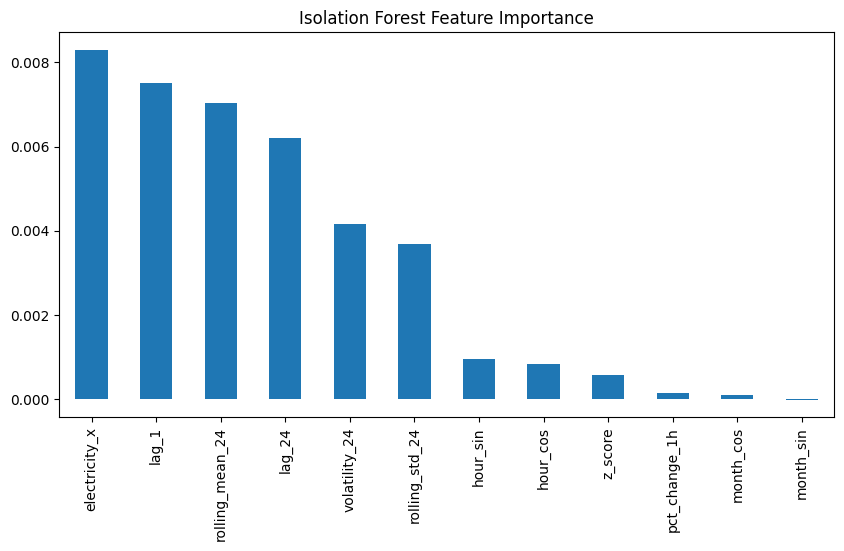

In [77]:
feature_importance.plot(kind="bar", figsize=(10,5))
plt.title("Isolation Forest Feature Importance")
plt.show()


In [78]:
iso_scores = iso_model.decision_function(X_scaled)
data["iso_score"] = iso_scores

importance_corr = (
    data[feature_cols]
    .corrwith(data["iso_score"])
    .abs()
    .sort_values(ascending=False)
)

print(importance_corr)


electricity_x      0.840706
lag_1              0.838842
rolling_mean_24    0.836313
lag_24             0.832056
volatility_24      0.642433
rolling_std_24     0.642433
month_sin          0.125590
z_score            0.104546
hour_cos           0.082837
hour_sin           0.039814
month_cos          0.033660
pct_change_1h      0.024976
dtype: float64


Hyperparameter tuning

Grid Search

In [79]:
from sklearn.ensemble import IsolationForest

In [80]:
param_grid = {
    "n_estimators": [100, 200],
    "contamination": [0.03, 0.05, 0.07],
    "max_samples": ["auto", 0.8]
}

results = []

for n in param_grid["n_estimators"]:
    for c in param_grid["contamination"]:
        for m in param_grid["max_samples"]:

            model = IsolationForest(
                n_estimators=n,
                contamination=c,
                max_samples=m,
                random_state=42,
                n_jobs=-1
            )

            preds = model.fit_predict(X_scaled)
            anomaly_rate = (preds == -1).sum() / len(preds) * 100

            results.append({
                "n_estimators": n,
                "contamination": c,
                "max_samples": m,
                "anomaly_rate_%": anomaly_rate
            })

tuning_results = pd.DataFrame(results)
print(tuning_results)

    n_estimators  contamination max_samples  anomaly_rate_%
0            100           0.03        auto        3.000016
1            100           0.03         0.8        3.000016
2            100           0.05        auto        5.000004
3            100           0.05         0.8        5.000004
4            100           0.07        auto        7.000062
5            100           0.07         0.8        7.000062
6            200           0.03        auto        3.000016
7            200           0.03         0.8        3.000016
8            200           0.05        auto        5.000004
9            200           0.05         0.8        5.000004
10           200           0.07        auto        7.000062
11           200           0.07         0.8        7.000062


TUNING LSTM AUTOENCODER

In [81]:
sequence_options = [12, 24, 48]

for seq_len in sequence_options:
    print(f"\nTesting sequence length: {seq_len}")

    X_seq = create_sequences(electricity_series, seq_len)
    X_seq = X_seq.reshape((X_seq.shape[0], X_seq.shape[1], 1))

    inputs = Input(shape=(seq_len, 1))
    encoded = LSTM(32, activation='relu')(inputs)
    decoded = RepeatVector(seq_len)(encoded)
    decoded = LSTM(32, activation='relu', return_sequences=True)(decoded)
    decoded = TimeDistributed(Dense(1))(decoded)

    model = Model(inputs, decoded)
    model.compile(optimizer='adam', loss='mse')

    model.fit(X_seq, X_seq, epochs=3, batch_size=64, verbose=0)

    pred = model.predict(X_seq)
    error = np.mean(np.abs(pred - X_seq), axis=(1,2))

    print("Mean reconstruction error:", np.mean(error))



Testing sequence length: 12
43946/43946 ━━━━━━━━━━━━━━━━━━━━ 184s 4ms/step
Mean reconstruction error: 2.207297

Testing sequence length: 24
43945/43945 ━━━━━━━━━━━━━━━━━━━━ 277s 6ms/step
Mean reconstruction error: 14.116483

Testing sequence length: 48
43945/43945 ━━━━━━━━━━━━━━━━━━━━ 520s 12ms/step
Mean reconstruction error: nan


In [82]:
for perc in [90, 92, 95, 97]:
    threshold = np.percentile(reconstruction_error, perc)
    anomaly_rate = (reconstruction_error > threshold).sum() / len(reconstruction_error) * 100
    print(f"Threshold {perc}% → Anomaly rate: {anomaly_rate:.2f}%")


Threshold 90% → Anomaly rate: 10.00%
Threshold 92% → Anomaly rate: 8.00%
Threshold 95% → Anomaly rate: 5.00%
Threshold 97% → Anomaly rate: 3.00%


ENSEMBLE TUNING

In [84]:
for rule in [1, 2]:
    ensemble = (data["iso_anomaly"] + data["lstm_anomaly"]) >= rule
    rate = ensemble.sum() / len(ensemble) * 100
    print(f"Rule >= {rule} → Anomaly rate: {rate:.2f}%")


Rule >= 1 → Anomaly rate: 6.00%
Rule >= 2 → Anomaly rate: 4.00%


In [85]:
iso_model = IsolationForest(
    n_estimators=200,
    contamination=0.05,
    max_samples=0.8,
    random_state=42,
    n_jobs=-1
)

iso_model.fit(X_scaled)


IsolationForest(contamination=0.05, max_samples=0.8, n_estimators=200,
                n_jobs=-1, random_state=42)

SAVE TRAINED MODELS

In [86]:
import joblib

# Save Isolation Forest
joblib.dump(iso_model, "isolation_forest_model.pkl")

# Save scaler
joblib.dump(scaler, "scaler.pkl")

print("Isolation Forest and scaler saved")


Isolation Forest and scaler saved


In [87]:
lstm_model.save("lstm_autoencoder_model.h5")

print("LSTM model saved")


LSTM model saved


In [88]:
model_metadata = {
    "sequence_length": sequence_length,
    "lstm_threshold": float(threshold),
    "feature_columns": feature_cols
}

joblib.dump(model_metadata, "model_metadata.pkl")

print(" Metadata saved")


 Metadata saved


In [89]:
data.to_parquet("anomaly_results.parquet", index=False)

print("Anomaly results saved")


Anomaly results saved


In [90]:
from google.colab import files

files.download("isolation_forest_model.pkl")
files.download("scaler.pkl")
files.download("lstm_autoencoder_model.h5")
files.download("model_metadata.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>